In [1]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler, DDIMInverseScheduler
from diffusers.models.attention_processor import AttnProcessor
from PIL import Image
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
import torch.nn.functional as F

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
# Load the ControlNet model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth")

# Initialize the Stable Diffusion pipeline with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", controlnet=controlnet
).to("cuda").to(torch.float16)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# Load and preprocess the input image
input_image = Image.open("/kaggle/input/bear-back/frame_00034.jpg").convert("RGB")
input_image = input_image.resize((512, 512))
input_image = np.array(input_image).astype(np.float32) / 255.0
input_image = torch.from_numpy(input_image).permute(2, 0, 1).unsqueeze(0).to("cuda").to(torch.float16)

In [4]:
# Encode the image to latents
vae = pipe.vae
latents = vae.encode(input_image * 2 - 1)["latent_dist"].mean * 0.18215

In [5]:
def load_and_preprocess_depth_map(image_path="depth_map.png", target_size=512):

    # Load depth map (8-bit or 16-bit grayscale image)
    depth_image = Image.open(image_path).convert("L")  # Convert to grayscale

    # Convert to float tensor
    depth_tensor = T.ToTensor()(depth_image).float()  # Shape: [1, H, W]

    # Expand to shape [1, 1, H, W]
    depth_tensor = depth_tensor.unsqueeze(0)  # Shape: [1, 1, H, W]

    # Convert to disparity
    epsilon = 1e-6
    disparity = 1.0 / (depth_tensor + epsilon)

    # Normalize disparity to [0, 1]
    disparity -= disparity.min()
    disparity /= (disparity.max() + 1e-8)

    # Resize to target model input (e.g., 512x512)
    disparity = F.interpolate(disparity, size=(target_size, target_size), mode='bilinear', align_corners=False)

    # Repeat to 3 channels for model
    disparity = disparity.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]

    return disparity


In [6]:
disparity = load_and_preprocess_depth_map("/kaggle/input/bear-back/image (1).webp")

In [7]:
# Set up the DDIM inversion scheduler
ddim_inverser = DDIMInverseScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
pipe.scheduler = ddim_inverser

# Perform DDIM inversion to obtain the initial noise
init_noise = pipe(prompt="", num_inference_steps=20, latents=latents, image=disparity, return_dict=False ,guidance_scale=0, output_type="latent")[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
# Set up the DDIM scheduler for generation
ddim_scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
pipe.scheduler = ddim_scheduler

# Set custom attention processors if needed
# pipe.unet.set_attn_processor(AttnProcessor())
# pipe.controlnet.set_attn_processor(AttnProcessor())

# Define the editing prompt
edit_prompt = "a polar bear"

# Perform the image editing
edited_image = pipe(
    prompt=edit_prompt,
    num_inference_steps=20,
    latents=init_noise,
    image=disparity,
    guidance_scale=1.255,
    controlnet_conditioning_scale=1.0,
    eta=0,
    output_type="pil"
).images[0]

# Save or display the edited image
edited_image.save("edited_image.jpg")
edited_image.show()

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
edited_image.size

(512, 512)

In [10]:
input_image.size()

torch.Size([1, 3, 512, 512])

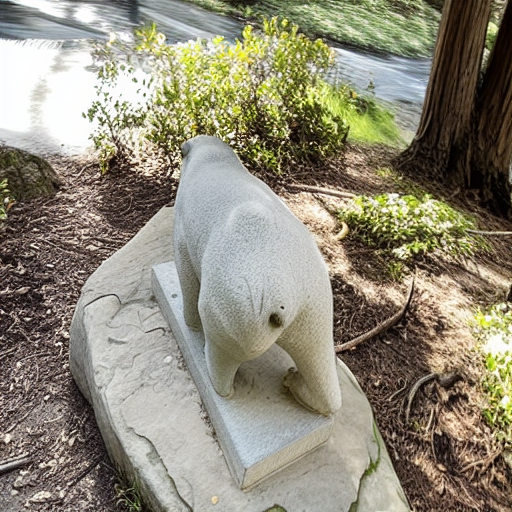

In [11]:
edited_image